In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
# import spearmanr from scipy.stats
from scipy.stats import spearmanr
# load data
horm_beh = np.load('preprocessed_hormones_behavior_last_animal.npy', allow_pickle=True).item()
X1m = horm_beh['X1m'].T
X1a = horm_beh['X1a'].T
X2m = horm_beh['X2m'].T
X2a = horm_beh['X2a'].T
X3 = horm_beh['X3'].T
y1m = horm_beh['y1m']
y1a = horm_beh['y1a']
y2m = horm_beh['y2m']
y2a = horm_beh['y2a']
y3 = horm_beh['y3']
common_comps = horm_beh['common_comps']

In [3]:
# robust z-score for each individual animal first
def robust_zscore(data, axis=0, log_transform=False, exclude_outliers=False, z_transform=False):
    if log_transform:
        data = np.log(data)
    median = np.nanmedian(data, axis=axis)
    mad = np.nanmedian(np.abs(data - median), axis=axis)
    if z_transform:
        zscore = (data - median) / mad
    else:
        zscore = data - median
    if exclude_outliers:
        zscore[np.abs(zscore) > 3] = np.nan
    return zscore

X1 = robust_zscore(np.concatenate([X1m, X1a], axis=0), log_transform=False)
X2 = robust_zscore(np.concatenate([X2m, X2a], axis=0), log_transform=False)
X3 = robust_zscore(X3, log_transform=False)

y1 = np.concatenate([y1m, y1a], axis=0)
y2 = np.concatenate([y2m, y2a], axis=0)
y3 = y3

In [73]:
len(y1), len(y2), len(y3)

(51, 61, 62)

In [4]:
# concatenate data
X = np.concatenate([X1, X2, X3], axis=0)
y = robust_zscore(np.concatenate([y1m, y1a, y2m, y2a, y3], axis=0), log_transform=True, z_transform=False)
n_samples, n_features = X.shape

In [5]:
# correlate histamine and behavior
from scipy.stats import pearsonr
histamine_idx = common_comps.index('Histamine')
r, p = spearmanr(X[:, histamine_idx], y)
print(f'Correlation between Histamine and Behavior: r={r:.3f}, p={p:.3e}')

Correlation between Histamine and Behavior: r=0.624, p=3.938e-20


In [6]:
max_lag = 5

In [7]:
# spearman R cross correlation
def spearman_ccf(x, y, max_lag):
    lags = np.arange(-max_lag+1, max_lag)
    ccf = [spearmanr(x[max_lag+lag:-max_lag+lag], 
                     y[max_lag: -max_lag])[0] for lag in lags]
    return lags, ccf

<StemContainer object of 3 artists>

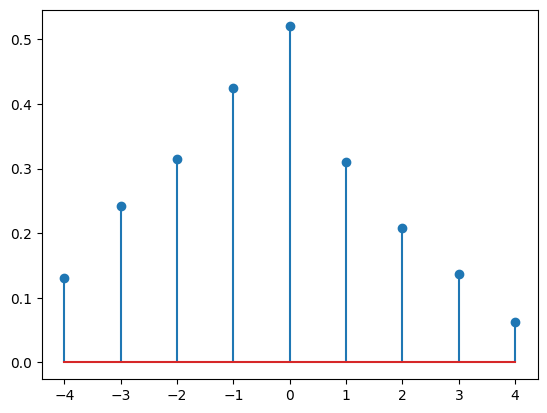

In [8]:
# compute cross correlaiton between histamine and histidine
histidine_idx = common_comps.index('Histidine')
histamine_idx = common_comps.index('Histamine')
lags, ccf_histamine_histidine = spearman_ccf(X[:, histamine_idx], X[:, histidine_idx],max_lag=5)
plt.figure()
plt.stem(lags, ccf_histamine_histidine)

In [9]:
# compute partial correlation between compounds in X1m taking into account y1m
from sklearn.linear_model import LinearRegression

# partial autocorrelation -- compute the autocorrelation of residuals?

def comp_resids(X, y):
    n_compounds = X.shape[1]
    resids = np.zeros_like(X)
    for i in range(n_compounds):
        model = LinearRegression().fit(y.reshape(-1, 1), X[:, i])
        resids[:, i] = X[:, i] - model.predict(y.reshape(-1, 1))
    return resids

In [21]:
# compute residuals of X1 and y1, X2 and y2, X3 and y3
X1_resids = comp_resids(X1, y1)
X2_resids = comp_resids(X2, y2)
X3_resids = comp_resids(X3, y3)

X_resids = np.concatenate([X1_resids, X2_resids, X3_resids], axis=0)

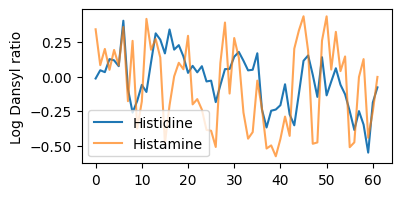

In [22]:
# plot histamine and histidine time series
plt.figure(figsize=(4, 2))
histidine_idx = common_comps.index('Histidine')
plt.plot(X3[:, histidine_idx], label='Histidine')
plt.ylabel('Log Dansyl ratio')
plt.plot(X3[:, histamine_idx], label='Histamine', alpha=0.7  )
plt.legend()

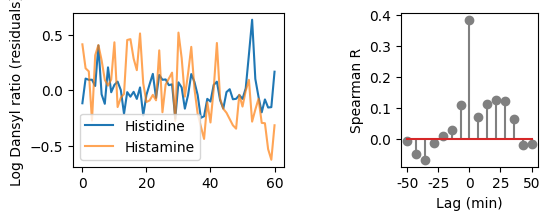

In [63]:
# plot histamine and histidine time series
plt.figure(figsize=(6, 2))
plt.subplot(121)
histidine_idx = common_comps.index('Histidine')
plt.plot(X2_resids[:, histidine_idx], label='Histidine')
plt.ylabel('Log Dansyl ratio (residuals)')
plt.plot(X2_resids[:, histamine_idx], label='Histamine', alpha=0.7  )
plt.legend()

plt.subplot(133)
histidine_idx = common_comps.index('Histidine')
histamine_idx = common_comps.index('Histamine')
lags, ccf_histamine_histidine = spearman_ccf(X_resids[:, histidine_idx],X_resids[:, histamine_idx],max_lag=8)
# stem with color grey
plt.stem(lags, ccf_histamine_histidine, linefmt='grey', markerfmt='o')
plt.xticks([-7,-3.5,0,3.5,7], [-50,-25,0,25,50])
plt.xlabel('Lag (min)')
plt.ylabel('Spearman R')
plt.savefig('histamine_histidine_ccg.pdf', dpi=300)

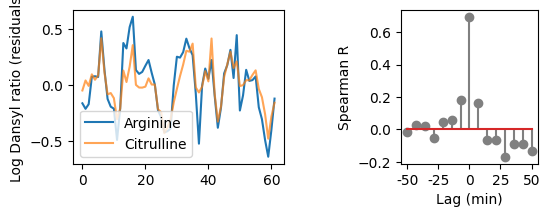

In [66]:
# same for arginine and citrulline
plt.figure(figsize=(6, 2))
plt.subplot(121)
arginine_idx = common_comps.index('Arginine')
citrulline_idx = common_comps.index('Citrulline')
plt.plot(X3_resids[:, arginine_idx], label='Arginine')
plt.ylabel('Log Dansyl ratio (residuals)')
plt.plot(X3_resids[:, citrulline_idx], label='Citrulline', alpha=0.7  )
plt.legend()    

plt.subplot(133)
arginine_idx = common_comps.index('Arginine')
citrulline_idx = common_comps.index('Citrulline')
lags, ccf_arginine_citrulline = spearman_ccf(X_resids[:, arginine_idx],X_resids[:, citrulline_idx],max_lag=8)
plt.stem(lags, ccf_arginine_citrulline, linefmt='grey', markerfmt='o')
plt.xticks([-7,-3.5,0,3.5,7], [-50,-25,0,25,50])
plt.xlabel('Lag (min)')
plt.ylabel('Spearman R')
plt.savefig('arginine_citrulline_ccg.pdf', dpi=300)

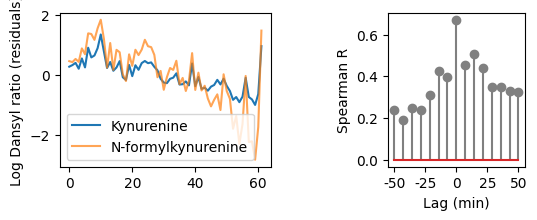

In [67]:
# Kynurenine and n-formylynurenine
plt.figure(figsize=(6, 2))
kynurenine_idx = common_comps.index('Kynurenine')
nformylynurenine_idx = common_comps.index('N-formylkynurenine')
plt.subplot(121)
plt.plot(X3_resids[:, kynurenine_idx], label='Kynurenine')
plt.ylabel('Log Dansyl ratio (residuals)')
plt.plot(X3_resids[:, nformylynurenine_idx], label='N-formylkynurenine', alpha=0.7  )
plt.legend()

plt.subplot(133)
lags, ccf_kynurenine_nformylynurenine = spearman_ccf(X_resids[:, kynurenine_idx],X_resids[:, nformylynurenine_idx],max_lag=8)
plt.stem(lags, ccf_kynurenine_nformylynurenine,linefmt='grey', markerfmt='o')
plt.xticks([-7,-3.5,0,3.5,7], [-50,-25,0,25,50])
plt.xlabel('Lag (min)')
plt.ylabel('Spearman R')
plt.savefig('kynurenine_nformylynurenine_ccg.pdf', dpi=300)



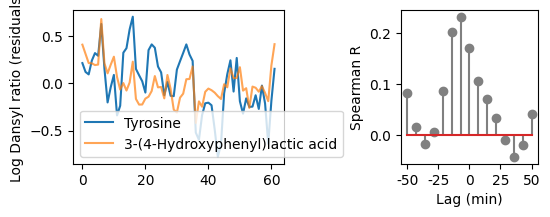

In [72]:
# Tyrosine → 3-(4-Hydroxyphenyl)lactic acid
plt.figure(figsize=(6, 2))
tyrosine_idx = common_comps.index('Tyrosine')
hpla_idx = common_comps.index('3-(4-Hydroxyphenyl)lactic acid')
plt.subplot(121)
plt.plot(X3_resids[:, tyrosine_idx], label='Tyrosine')
plt.ylabel('Log Dansyl ratio (residuals)')
plt.plot(X3_resids[:, hpla_idx], label='3-(4-Hydroxyphenyl)lactic acid', alpha=0.7  )
plt.legend()

plt.subplot(133)
lags, ccf_tyrosine_hpla = spearman_ccf(X_resids[:, tyrosine_idx],X_resids[:, hpla_idx],max_lag=8)
plt.stem(lags, ccf_tyrosine_hpla,linefmt='grey', markerfmt='o')
plt.xticks([-7,-3.5,0,3.5,7], [-50,-25,0,25,50])
plt.xlabel('Lag (min)')
plt.ylabel('Spearman R')
plt.savefig('tyrosine_hpla_ccg.pdf', dpi=300)